# Plotting cross-sections

This Notebook takes the receiver output files of a SeisSol simulation and can plot the particle velocity along the trace given by the receivers as well as generate a distance-time figure.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
from cmcrameri import cm

plt.rcParams["font.family"] = "serif"
plt.rc('xtick', labelsize=11) 
plt.rc('ytick', labelsize=11)

In [2]:
directory = "/import/freenas-m-04-students/fkutschera/simulations/HFFZ_fullycp_o5_180s_II/"
file = "HFFZ_full-receiver-00483-00008.dat"
column_names = ["Time","xx","yy","zz","xy","yz","xz","v1","v2","v3"]

# Single receiver

In [3]:
df = pd.read_csv(directory+file, skiprows=5, sep='\s+', names=column_names)
df.drop(columns=["xx","yy","zz","xy","yz","xz"], inplace=True)
df.head()

,Time,v1,v2,v3
0,0.0,0.000000e+00,0.000000e+00,0.000000e+00
1,0.1,0.000000e+00,0.000000e+00,0.000000e+00
2,0.2,0.000000e+00,0.000000e+00,0.000000e+00
3,0.3,-2.359903e-133,6.971712e-134,1.713360e-133
4,0.4,-1.473553e-95,1.093060e-95,1.121700e-95


In [4]:
coords = pd.read_csv(directory+file, nrows=3, skiprows=2, header=None, sep="\s+") 
x1 = coords[2][0]
x2 = coords[2][1]
x3 = coords[2][2]

In [5]:
df["x1"]=x1
df["x2"]=x2
df["x3"]=x3
df.head()

,Time,v1,v2,v3,x1,x2,x3
0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,623500.4,7345316.0,-0.1
1,0.1,0.000000e+00,0.000000e+00,0.000000e+00,623500.4,7345316.0,-0.1
2,0.2,0.000000e+00,0.000000e+00,0.000000e+00,623500.4,7345316.0,-0.1
3,0.3,-2.359903e-133,6.971712e-134,1.713360e-133,623500.4,7345316.0,-0.1
4,0.4,-1.473553e-95,1.093060e-95,1.121700e-95,623500.4,7345316.0,-0.1


Text(0.5, 1.0, 'receiver HFFZ_full-receiver-00483-00008.dat with x1 = 623500.4, x2 = 7345316.0, x3 = -0.1')

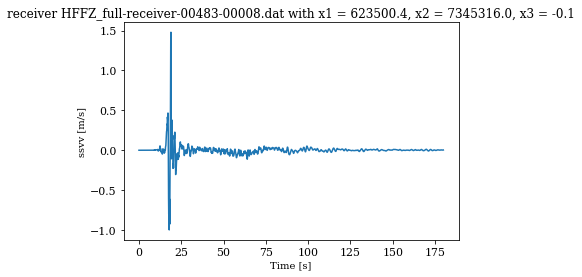

In [6]:
plt.plot(df.Time,df.v3)
plt.xlabel("Time [s]")
plt.ylabel("ssvv [m/s]")
plt.title("receiver {} with x1 = {}, x2 = {}, x3 = {}".format(file, x1, x2, x3))

In [7]:
max(df.Time)

179.8999999999941

In [8]:
# need to adjust time due to floating point errors/ rounding
time_length = 1800
time_array = np.linspace(0, 179.9, time_length)
df["Time"] = time_array
df.loc[df['Time'] == 40.0]

,Time,v1,v2,v3,x1,x2,x3
400,40.0,-0.025406,-0.036261,0.025252,623500.4,7345316.0,-0.1


In [9]:
max(df.Time)

179.9

# Receiver line with selected time

In [10]:
files = glob.glob(os.path.join(directory, "HFFZ_full-receiver*.dat"))

In [11]:
for f in files:
    frame = pd.read_csv(f, skiprows=5, sep='\s+', names=column_names)
    frame.drop(columns=["xx","yy","zz","xy","yz","xz"], inplace=True)
    coords = pd.read_csv(f, nrows=3, skiprows=2, header=None, sep="\s+")
    x1 = coords[2][0]
    x2 = coords[2][1]
    x3 = coords[2][2]
    frame["x1"]=x1
    frame["x2"]=x2
    frame["x3"]=x3
    if (files[0]==f):
        stack = frame.loc[df['Time'] == 20.0]
    else:
        stack = pd.concat([stack, frame.loc[df['Time'] == 20.0]])

In [12]:
stack.sort_values(by="x1", inplace=True)

In [13]:
stack

,Time,v1,v2,v3,x1,x2,x3
200,20.0,0.000475,-0.000091,-0.017425,612800.0,7327000.0,-0.1
200,20.0,0.001114,0.002929,-0.017835,612822.2,7327038.0,-0.1
200,20.0,-0.000354,0.000189,-0.018036,612844.4,7327076.0,-0.1
200,20.0,-0.001399,0.000155,-0.017835,612866.6,7327114.0,-0.1
200,20.0,-0.002116,0.000039,-0.017665,612888.8,7327152.0,-0.1
...,...,...,...,...,...,...,...
200,20.0,-0.000247,0.000027,-0.004812,634911.2,7364848.0,-0.1
200,20.0,-0.000246,0.000110,-0.005778,634933.4,7364886.0,-0.1
200,20.0,-0.000243,0.000274,-0.006922,634955.6,7364924.0,-0.1
200,20.0,-0.000255,0.000452,-0.008695,634977.8,7364962.0,-0.1


Text(0.5, 1.0, 'receiver line with x3 = -0.1')

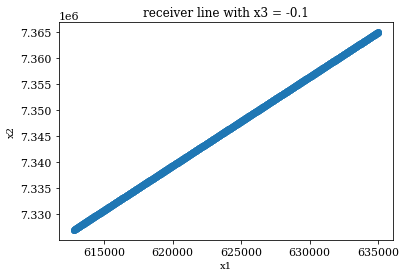

In [14]:
plt.plot(stack.x1,stack.x2,'o')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("receiver line with x3 = {}".format(x3))

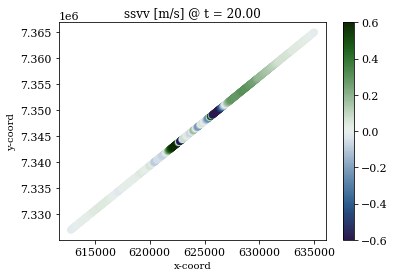

In [15]:
sc = plt.scatter(stack.x1,stack.x2, c=stack.v3, vmin=-0.6, vmax=0.6, s=40, cmap=cm.cork)
plt.colorbar(sc)
plt.xlabel("x-coord")
plt.ylabel("y-coord")
plt.title("ssvv [m/s] @ t = {:.2f}".format(stack["Time"].iloc[0]))
plt.show()

In [16]:
# calculate distance
#stack['Distance'] = 0
#for i in range(len(stack)-1):
#    stack['Distance'].iloc[i+1] = stack['Distance'].iloc[i] + np.sqrt((stack['x1'].iloc[i+1] - stack['x1'].iloc[i])**2 + (stack['x2'].iloc[i+1] - stack['x2'].iloc[i])**2)
#stack

In [17]:
length_xy = np.sqrt((stack['x1'].iloc[0] - stack['x1'].iloc[-1])**2 + (stack['x2'].iloc[0] - stack['x2'].iloc[-1])**2)
length_xy = length_xy/1000 # km
length_xy

44.0095444193643

In [18]:
#plt.plot(stack.Distance, stack.w)

# Compute with geopy and check result

Uses geopy and pyproj.

In [19]:
def conversion_xy2length(x_start,y_start,x_end,y_end):
    from pyproj import Transformer
    transformer = Transformer.from_crs("utm27", "epsg:4326", always_xy=True)
    lon_start, lat_start = transformer.transform(x_start, y_start)
    lon_end, lat_end = transformer.transform(x_end, y_end)
    print(lon_start, lat_start)
    print(lon_end, lat_end)
    
    import geopy.distance # ATTENTION: geopy needs LAT first
    coords_1 = (lat_start, lon_start)
    coords_2 = (lat_end, lon_end)
    length = geopy.distance.geodesic(coords_1, coords_2).km
    return length 

In [20]:
x_start = stack['x1'].iloc[0]
y_start = stack['x2'].iloc[0]
x_end = stack["x1"].iloc[len(stack)-1]
y_end = stack["x2"].iloc[len(stack)-1]

length_geopy = conversion_xy2length(x_start,y_start,x_end,y_end)
length_geopy # in km

-18.50973402024824 66.04162265764434
-17.980037997663672 66.37337956937641


44.01841358482034

In [21]:
if (round(length_xy, 1) == round(length_geopy, 1)):
    print("Distance agrees.")

Distance agrees.


In [23]:
# Create distance array for plotting
distance = length_xy
distance = np.linspace(0,length_xy,len(stack))
len(distance)

1001

# Trace along receiver line at specific time

Text(0.5, 1.0, 'trace @ t = 20.00')

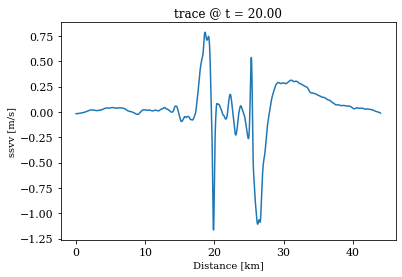

In [24]:
plt.plot(distance, stack.v3)
plt.xlabel("Distance [km]")
plt.ylabel("ssvv [m/s]")
plt.title("trace @ t = {:.2f}".format(stack["Time"].iloc[0]))

# 2D contour plot at specific time 

In [25]:
stack.head()

,Time,v1,v2,v3,x1,x2,x3
200,20.0,0.000475,-0.000091,-0.017425,612800.0,7327000.0,-0.1
200,20.0,0.001114,0.002929,-0.017835,612822.2,7327038.0,-0.1
200,20.0,-0.000354,0.000189,-0.018036,612844.4,7327076.0,-0.1
200,20.0,-0.001399,0.000155,-0.017835,612866.6,7327114.0,-0.1
200,20.0,-0.002116,0.000039,-0.017665,612888.8,7327152.0,-0.1


In [26]:
# Create time array for plotting - already created before
#time_array = np.linspace(0, 179.9, time_length)
time_array

array([0.000e+00, 1.000e-01, 2.000e-01, ..., 1.797e+02, 1.798e+02,
       1.799e+02])

In [27]:
DISTANCE, TIME = np.meshgrid(distance, time_array)

In [28]:
ssva = (stack.v3)
ssva

200   -0.017425
200   -0.017835
200   -0.018036
200   -0.017835
200   -0.017665
         ...   
200   -0.004812
200   -0.005778
200   -0.006922
200   -0.008695
200   -0.012426
Name: v3, Length: 1001, dtype: float64

In [29]:
DISTANCE.shape, TIME.shape, ssva.shape

((1800, 1001), (1800, 1001), (1001,))

In [30]:
SSVA = np.tile(ssva, (time_length, 1)) # Construct an array by repeating A the number of times given by reps.
SSVA.shape

(1800, 1001)

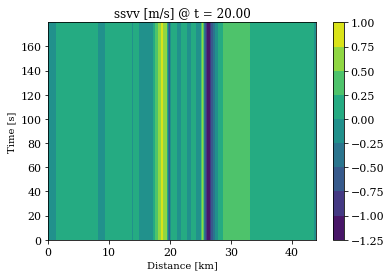

In [31]:
plt.contourf(DISTANCE, TIME, SSVA)
plt.xlabel("Distance [km]")
plt.ylabel("Time [s]")
plt.title("ssvv [m/s] @ t = {:.2f}".format(stack["Time"].iloc[0]))
plt.colorbar()

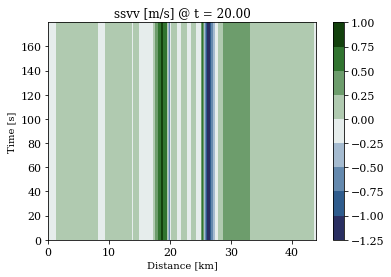

In [32]:
h = plt.contourf(DISTANCE, TIME, SSVA, cmap=cm.cork)
plt.xlabel("Distance [km]")
plt.ylabel("Time [s]")
plt.title("ssvv [m/s] @ t = {:.2f}".format(stack["Time"].iloc[0]))
plt.colorbar(h)

# 2D contour plot over all times

In [33]:
for f in files:
    frame = pd.read_csv(f, skiprows=5, sep='\s+', names=column_names)
    frame.drop(columns=["xx","yy","zz","xy","yz","xz"], inplace=True)
    coords = pd.read_csv(f, nrows=3, skiprows=2, header=None, sep="\s+")
    x1 = coords[2][0]
    x2 = coords[2][1]
    x3 = coords[2][2]
    frame["x1"]=x1
    frame["x2"]=x2
    frame["x3"]=x3
    if (files[0]==f):
        total_stack = frame
    else:
        total_stack = pd.concat([total_stack, frame])

In [34]:
# need to adjust time due to floating point errors/ rounding
print(max(df.Time))
df["Time"] = np.linspace(0, 179.9, time_length)
print(max(df.Time))

179.9
179.9


In [35]:
total_stack

,Time,v1,v2,v3,x1,x2,x3
0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,612999.8,7327342.0,-0.1
1,0.1,0.000000e+00,0.000000e+00,0.000000e+00,612999.8,7327342.0,-0.1
2,0.2,0.000000e+00,0.000000e+00,0.000000e+00,612999.8,7327342.0,-0.1
3,0.3,5.756612e-141,1.574813e-139,1.718937e-139,612999.8,7327342.0,-0.1
4,0.4,4.821939e-92,-9.498201e-92,1.527086e-92,612999.8,7327342.0,-0.1
...,...,...,...,...,...,...,...
1795,179.5,1.405667e-02,2.112025e-03,7.066004e-03,624521.6,7347064.0,-0.1
1796,179.6,1.405321e-02,2.125144e-03,7.617441e-03,624521.6,7347064.0,-0.1
1797,179.7,1.405052e-02,2.138451e-03,7.636804e-03,624521.6,7347064.0,-0.1
1798,179.8,1.404857e-02,2.151881e-03,7.138508e-03,624521.6,7347064.0,-0.1


In [36]:
# Sort first by Time and then by coorindates
total_stack.sort_values(['Time', 'x1'], inplace=True)

In [37]:
#total_stack.to_csv("total_stack_sorted.csv")

In [38]:
total_stack

,Time,v1,v2,v3,x1,x2,x3
0,0.0,0.000000,0.000000,0.000000,612800.0,7327000.0,-0.1
0,0.0,0.000000,0.000000,0.000000,612822.2,7327038.0,-0.1
0,0.0,0.000000,0.000000,0.000000,612844.4,7327076.0,-0.1
0,0.0,0.000000,0.000000,0.000000,612866.6,7327114.0,-0.1
0,0.0,0.000000,0.000000,0.000000,612888.8,7327152.0,-0.1
...,...,...,...,...,...,...,...
1799,179.9,0.001422,-0.000048,-0.006431,634911.2,7364848.0,-0.1
1799,179.9,0.001431,0.000019,-0.006594,634933.4,7364886.0,-0.1
1799,179.9,0.001432,0.000041,-0.006769,634955.6,7364924.0,-0.1
1799,179.9,0.001430,0.000078,-0.006978,634977.8,7364962.0,-0.1


In [39]:
ssva = (total_stack.v3)

In [40]:
print(max(ssva))
print(min(ssva))

1.639061360977977
-1.631129340809321


In [41]:
ssva.shape

(1801800,)

In [42]:
#SSVA = ssva.reshape(len(distance), time_length)
SSVA = ssva.values.reshape(-1, len(distance))  # same as above: a1.reshape(3, 4)

In [43]:
SSVA.shape

(1800, 1001)

In [44]:
levels = np.linspace(-0.1, 0.1, 21)

In [49]:
import matplotlib as mpl
cmap = mpl.cm.get_cmap("viridis").copy()
#cmap.set_extremes(under='black', over='yellow')

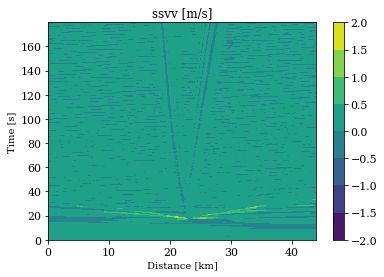

In [50]:
# DISTANCE and TIME were created before
plt.contourf(DISTANCE, TIME, SSVA, cmap=cmap)
plt.xlabel("Distance [km]")
plt.ylabel("Time [s]")
plt.title("ssvv [m/s]")
plt.colorbar()

Text(0.5, 1.0, 'ssvv [m/s]')

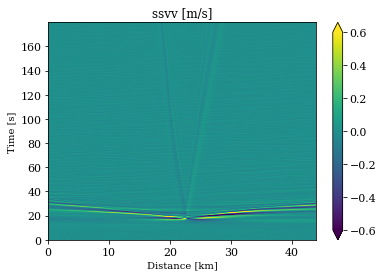

In [56]:
plt.imshow(SSVA, extent=[distance[0], distance[-1], time_array[0], time_array[-1]], origin='lower', aspect='auto',
           vmin=-0.6, vmax=0.6, cmap=cmap)
plt.colorbar(extend="both")
plt.xlabel("Distance [km]")
plt.ylabel("Time [s]")
plt.title("ssvv [m/s]")

(15.0, 45.0)

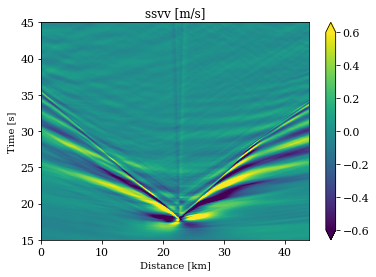

In [57]:
plt.imshow(SSVA, extent=[distance[0], distance[-1], time_array[0], time_array[-1]], origin='lower', aspect='auto',
          vmin=-0.6, vmax=0.6, cmap=cmap)
plt.colorbar(extend = 'both')
plt.xlabel("Distance [km]")
plt.ylabel("Time [s]")
plt.title("ssvv [m/s]")
plt.ylim(15,45)

(15.0, 45.0)

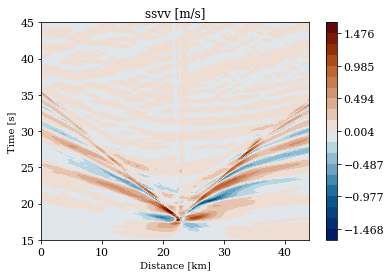

In [58]:
levels = np.linspace(min(ssva), max(ssva), 21)
CS = plt.contourf(DISTANCE, TIME, SSVA, cmap=cm.vik, levels=levels)
plt.xlabel("Distance [km]")
plt.ylabel("Time [s]")
plt.title("ssvv [m/s]")
plt.colorbar(CS)
plt.ylim(15,45)

Text(0.5, 1.0, 'ssvv [m/s]')

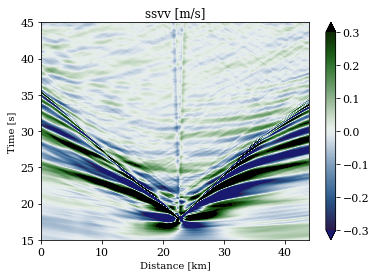

In [59]:
cmap = plt.get_cmap(cm.cork).copy()
cmap.set_extremes(under='midnightblue', over='black')

plt.imshow(SSVA, extent=[distance[0], distance[-1], time_array[0], time_array[-1]], origin='lower', aspect='auto',
          vmin=-0.3, vmax=0.3, cmap=cmap)
plt.colorbar(extend = 'both')
plt.xlabel("Distance [km]")
plt.ylabel("Time [s]")
plt.ylim(15,45)
plt.title("ssvv [m/s]")

# Compute and plot different velocities - double check!

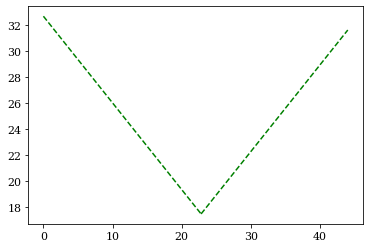

In [62]:
xr = np.linspace(22.8, max(distance), 1000)
xl = np.linspace(0, 22.8, 1000)
slope = 2/3 # km/s (inv dx/dy)
yr = slope*xr - slope*xr[0] + 17.5
yl = -slope*xl + slope*xl[-1] + 17.5
plt.plot(xr, yr, '--g') # dashed 
plt.plot(xl, yl, '--g') # dashed 

(15.0, 45.0)

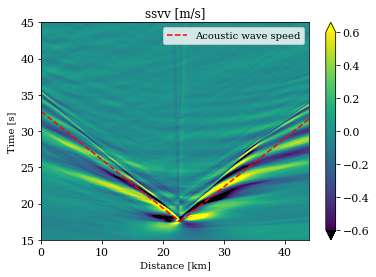

In [63]:
cmap = mpl.cm.get_cmap("viridis").copy()
cmap.set_extremes(under='black', over='yellow')
plt.imshow(SSVA, extent=[distance[0], distance[-1], time_array[0], time_array[-1]], origin='lower', aspect='auto',
          vmin=-0.6, vmax=0.6, cmap=cmap)
plt.colorbar(extend = 'both')
plt.xlabel("Distance [km]")
plt.ylabel("Time [s]")
plt.title("ssvv [m/s]")
plt.plot(xr, yr, '--r', label="Acoustic wave speed")
plt.plot(xl, yl, '--r')
plt.legend()
plt.ylim(15,45)

In [184]:
#35/(41-17.5)
22.9/(33-17)

1.43125